In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt


In [2]:
assets = ["SPY", "TLT", "GLD", "QQQ"]
prices = yf.download(assets, start="2017-01-01", end="2025-01-16")["Close"]
prices = prices.dropna()
prices

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


Ticker,GLD,QQQ,SPY,TLT
Date,,,,
2017-01-03,110.470001,112.422150,194.998932,93.518333
2017-01-04,110.860001,113.033447,196.159073,93.877876
2017-01-05,112.580002,113.672974,196.003204,95.347397
2017-01-06,111.750000,114.669853,196.704468,94.471954
2017-01-09,112.669998,115.046021,196.055145,95.230156
...,...,...,...,...
2025-01-08,245.860001,512.669922,582.647827,82.364334
2025-01-10,248.210007,504.630737,573.752319,81.818611
2025-01-13,245.740005,503.008911,574.641907,81.789917


## Getiriler ve Kovaryans

In [3]:
returns = prices.pct_change().dropna()
cov_matrix = returns.cov()
cov_matrix

Ticker,GLD,QQQ,SPY,TLT
Ticker,,,,
GLD,0.000076,0.000014,0.000010,0.000026
QQQ,0.000014,0.000207,0.000155,-0.000016
SPY,0.000010,0.000155,0.000134,-0.000020
TLT,0.000026,-0.000016,-0.000020,0.000096


## Portföy Volatilitesi

In [4]:
def portfolio_volatility(w, cov):
    return np.sqrt(w.T @ cov @ w)


## Risk Katkısı

In [5]:
def risk_contribution(w, cov):
    port_var = w.T @ cov @ w
    marginal_contrib = cov @ w
    rc = w * marginal_contrib / port_var
    return rc


## Amaç Fonksiyonu (Risk Parity)

In [6]:
def risk_parity_objective(w, cov):
    rc = risk_contribution(w, cov)
    target = np.ones(len(w)) / len(w)
    return np.sum((rc - target) ** 2)


## Optimizasyon

In [7]:
n = len(assets)
w0 = np.ones(n) / n

constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
bounds = [(0, 1)] * n

result = minimize(
    risk_parity_objective,
    w0,
    args=(cov_matrix,),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints
)

risk_parity_weights = result.x
risk_parity_weights

array([0.29805233, 0.16194866, 0.21233532, 0.3276637 ])

## Equal Weight

In [8]:
equal_weights = np.ones(n) / n

rp_returns = returns @ risk_parity_weights
ew_returns = returns @ equal_weights
rp_returns
ew_returns

Date
2017-01-04    0.004690
2017-01-05    0.009008
2017-01-06   -0.001052
2017-01-09    0.004059
2017-01-10    0.001453
                ...   
2025-01-08    0.002058
2025-01-10   -0.007004
2025-01-13   -0.002991
2025-01-14    0.001009
2025-01-15    0.016480
Length: 2020, dtype: float64

## Sharpe Oranı

In [9]:
def sharpe_ratio(r):
    return np.sqrt(252) * r.mean() / r.std()

print("Risk Parity Sharpe:", sharpe_ratio(rp_returns))
print("Equal Weight Sharpe:", sharpe_ratio(ew_returns))


Risk Parity Sharpe: 0.9687952490564903
Equal Weight Sharpe: 1.0352153889270728


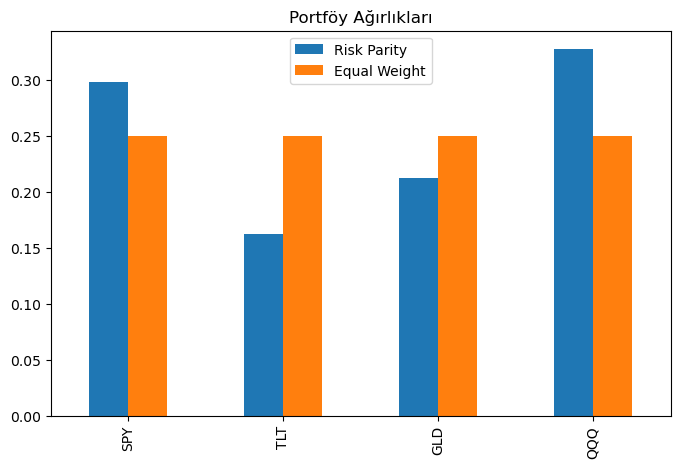

In [10]:
pd.DataFrame({
    "Risk Parity": risk_parity_weights,
    "Equal Weight": equal_weights
}, index=assets).plot(kind="bar", figsize=(8,5))
plt.title("Portföy Ağırlıkları")
plt.show()


Portföy Ağırlıkları Analizi
Equal Weight (Turuncu)
Her varlığa %25 pay verilmiş - standart eşit ağırlık stratejisi.
Risk Parity (Mavi) - Stratejik Dağılım
En yüksek paylar:

QQQ: %33
SPY: %30

En düşük paylar:

GLD: %21
TLT: %16

Önemli Gözlem
Risk Parity stratejisinde volatil hisse senetlerine (QQQ, SPY) daha fazla pay verilmiş. Bu mantıksız görünebilir çünkü risk dengelemesi bekliyoruz.
Açıklama:
Strateji düşük volatiliteli varlıklara (özellikle TLT) kaldıraç uygulayarak risk katkılarını dengeliyor:

TLT: %16 pay → Kaldıraçla çarpılınca → %25 risk katkısı
QQQ: %33 pay → Kaldıraçsız → %25 risk katkısı

Bu sayede nominal ağırlıklar farklı olsa da her varlığın portföy riskine katkısı eşitleniyor. Risk Parity'nin temel prensibi bu şekilde korunuyor.

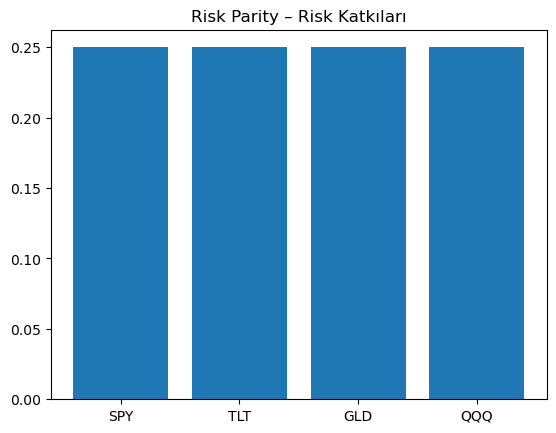

In [11]:
rc = risk_contribution(risk_parity_weights, cov_matrix)

plt.bar(assets, rc)
plt.title("Risk Parity – Risk Katkıları")
plt.show()


Risk Parity - Risk Katkıları Analizi
Bu grafik Risk Parity stratejisinin temel prensibini gösteriyor:
Eşit Risk Katkısı

SPY, TLT, GLD ve QQQ'nun hepsi portföy riskine tam olarak %25 katkıda bulunuyor

Bu Nasıl Başarılıyor?
Bir önceki grafikte gördüğümüz gibi:

QQQ'ya %33 pay verilmişti (en yüksek volatilite)
TLT'ye %16 pay verilmişti (en düşük volatilite)

Ancak TLT'ye kaldıraç uygulanarak her ikisinin de risk katkısı %25'e eşitlenmiş.

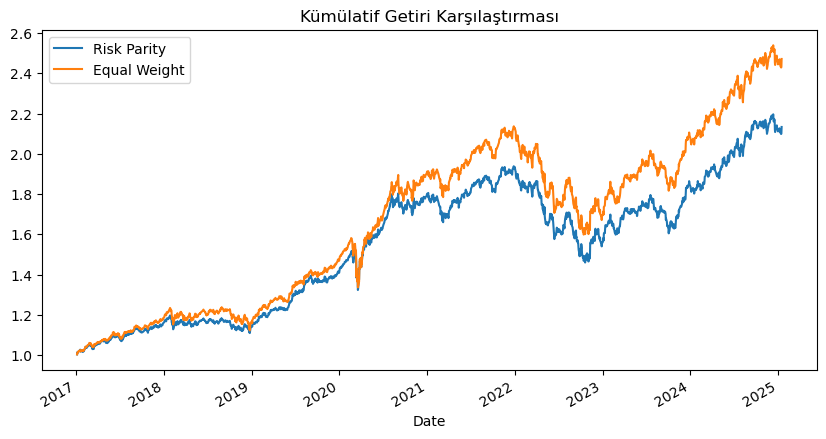

In [12]:
(1 + rp_returns).cumprod().plot(label="Risk Parity", figsize=(10,5))
(1 + ew_returns).cumprod().plot(label="Equal Weight")
plt.legend()
plt.title("Kümülatif Getiri Karşılaştırması")
plt.show()


Kümülatif Getiri Karşılaştırması
Genel Performans (2017-2025)

Equal Weight: 2.5x getiri (%150)
Risk Parity: 2.1x getiri (%110)

Dönemsel Analiz
2017-2020: Paralel Hareket

Her iki strateji benzer performans gösterdi
Mart 2020 COVID şokunda birlikte düştüler

2020-2022: Equal Weight Üstünlüğü

Equal Weight 2.1'e kadar çıktı
Risk Parity 1.9'da kaldı
Hisse senedi piyasasının güçlü olduğu dönem

2022: Kritik Ayrım Noktası

Equal Weight: 2.1'den 1.6'ya düştü (-%24)
Risk Parity: 1.9'dan 1.5'e düştü (-%21)
Risk Parity düşüşte daha az kayıp verdi

2023-2025: Toparlanma

Equal Weight 2.5'e yükseldi
Risk Parity 2.1'de kaldı
Mutlak getiri farkı açıldı

Sonuç
Equal Weight için: Toplam getiri daha yüksek, ancak volatilite fazla. Boğa piyasasında kazandırıyor.
Risk Parity için: Daha düşük getiri ama düşüş dönemlerinde koruma sağlıyor. Grafikte çizgi daha düzgün - risk yönetimi açısından başarılı.